In [1]:
import scanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Cargar datos

Leemos los datos

In [2]:
rep1 = scanpy.read_10x_mtx("data/WT1", make_unique=True)
rep2 = scanpy.read_10x_mtx("data/WT2", make_unique=True)
rep3 = scanpy.read_10x_mtx("data/WT3", make_unique=True)

all_data = scanpy.concat([rep1, rep2, rep3])

# Ver cómo funciona esto
all_data.obs_names_make_unique()

/home/rodrigo/.local/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['PEX3-1']
  warnings.warn(
/home/rodrigo/.local/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['PEX3-1']
  warnings.warn(
/home/rodrigo/.local/lib/python3.10/site-packages/anndata/utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar s

### Create gene name mapping (from "gene symbols" to TAIR IDs)

Write gene names to a text file. This will be loaded by an R script which will query Biomart for the corresponding TAIR IDs (gene IDs that start with `AT`), this is important for filtering the chloroplastic and mitochondrial genes which are recognized by their names.

In [3]:
with open("gene_names.txt", "wt") as genes_f:
    genes_f.write("\n".join(all_data.var_names.to_list()))

In [4]:
# genename_mapping = pd.read_csv("gene_symbols_to_tair_ids.txt")
# genename_mapping = { row.external_gene_name: row.tair_locus for index, row in genename_mapping.iterrows() }

___

In [5]:
print(f"Hay {len(rep1.obs_names)} células")
print(f"Hay {len(rep1.var_names)} genes")

print(f"Hay {len(rep2.obs_names)} células")
print(f"Hay {len(rep2.var_names)} genes")

print(f"Hay {len(rep3.obs_names)} células")
print(f"Hay {len(rep3.var_names)} genes")

print(f"Hay {len(all_data.obs_names)} células")
print(f"Hay {len(all_data.var_names)} genes")

Hay 21742 células
Hay 27546 genes
Hay 7121 células
Hay 27546 genes
Hay 12319 células
Hay 27546 genes
Hay 41182 células
Hay 27546 genes


___
Filter cells for at least 3 genes, filter genes for at least 200 cells.

In [6]:
MIN_GENES, MIN_CELLS = 3, 200

In [7]:
scanpy.pp.filter_cells(all_data, min_genes=MIN_GENES)
print(all_data.shape)
scanpy.pp.filter_genes(all_data, min_cells=MIN_CELLS)
print(all_data.shape)

(41182, 27546)
(41182, 15281)


Identify chloroplastic and mitocondrial genes:

In [8]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
genename_mapping_df = gp.convert(all_data.var_names.to_list(), organism="athaliana", target_namespace="TAIR_LOCUS")

In [9]:
genename_mapping_df.head()

,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,NAC001,AT1G01010,1,1,NAC001,NAC domain containing protein 1 [Source:NCBI g...,"ENTREZGENE,UNIPROT_GN,WIKIGENE",query_1
1,ARV1,AT1G01020,2,1,ARV1,ARV1 family protein [Source:NCBI gene (formerl...,"ENTREZGENE,TAIR_SYMBOL,UNIPROT_GN,WIKIGENE",query_1
2,NGA3,AT1G01030,3,1,NGA3,AP2/B3-like transcriptional factor family prot...,"ENTREZGENE,TAIR_SYMBOL,UNIPROT_GN,WIKIGENE",query_1
3,DCL1,AT1G01040,4,1,DCL1,dicer-like 1 [Source:NCBI gene (formerly Entre...,"ENTREZGENE,TAIR_SYMBOL,UNIPROT_GN,WIKIGENE",query_1
4,PPA1,AT1G01050,5,1,PPa1,pyrophosphorylase 1 [Source:NCBI gene (formerl...,"ENTREZGENE,UNIPROT_GN,WIKIGENE",query_1


Creamos un diccionario para usar luego:

In [10]:
genename_mapping = {row.incoming: row.converted for i, row in genename_mapping_df.iterrows()}

In [11]:
def get_chloroplast_genes(adata: scanpy.AnnData):
    return adata.var_names[tair_ids.str.startswith("ATCG")].to_list()

def get_mitochondrial_genes(adata: scanpy.AnnData):
    return adata.var_names[tair_ids.str.startswith("ATMG")].to_list()

In [12]:
tair_ids = pd.Series(all_data.var_names).apply(lambda x: genename_mapping.get(x, x))

chloroplast_genes     = get_chloroplast_genes(all_data)
mitochondrial_genes   = get_mitochondrial_genes(all_data)

In [13]:
print(f"Chloroplastic genes: {chloroplast_genes}")
print(f"Mitochondrial genes: {mitochondrial_genes}")

all_data.shape

Chloroplastic genes: ['RPS12A', 'RPS12C', 'RPS14', 'RPS2', 'RPS19', 'PSBA', 'MATK', 'RPS16', 'PSBK', 'PSBI', 'ATPA', 'ATPF', 'ATPH', 'ATPI', 'RPOC2', 'RPOC1', 'RPOB', 'PETN', 'PSBM', 'PSBD', 'PSBC', 'PSBZ', 'PSAB', 'PSAA', 'YCF3', 'NDHJ', 'NDHK', 'NDHC', 'ATPE', 'ATPB', 'RBCL', 'ACCD', 'PSAI', 'YCF4', 'CEMA', 'PETA', 'PSBJ', 'PSBL', 'PSBF', 'PSBE', 'ORF31', 'PETG', 'PSAJ', 'RPL33', 'RPS18', 'RPL20', 'CLPP1', 'PSBB', 'PSBT', 'PSBN', 'PSBH', 'PETB', 'PETD', 'RPOA', 'RPS11', 'RPL36', 'RPS8', 'RPL14', 'RPL22', 'NDHF', 'RPL32', 'CCSA', 'NDHD', 'PSAC', 'NDHE', 'NDHG', 'NDHI', 'NDHA', 'NDHH', 'RPS15', 'YCF1.2']
Mitochondrial genes: ['RPS7', 'RPL5', 'RPS4', 'COB', 'cox2', 'rps3', 'rpl16', 'nad9', 'atp1', 'cox1', 'nad6', 'ccmFC', 'nad4', 'rpl2', 'matR', 'nad7', 'atp6-1', 'ccmFN1', 'nad4L', 'RPL16', 'RPS3']


(41182, 15281)

In [14]:
all_data.obs['percent_pt'] = (
    all_data[:, chloroplast_genes].X.sum(axis=1) / all_data.X.sum(axis=1)
) * 100  # Convert to percentage

all_data.obs['percent_mt'] = (
    all_data[:, mitochondrial_genes].X.sum(axis=1) / all_data.X.sum(axis=1)
) * 100

Examinemos las células con un porcentaje de genes protoplásticos mayor al 5%.

In [15]:
all_data.obs['percent_pt'][all_data.obs['percent_pt'] > 5]

AAACCCAAGCCGATCC-1     8.654938
AAACCCAAGGAAAGTG-1     5.811916
AAACCCAAGGCCACCT-1     7.680491
AAACCCAAGGGACCAT-1     6.090740
AAACCCAAGTAGAGTT-1    18.207681
                        ...    
TTTGTTGCAACGGCTC-1    24.706414
TTTGTTGCAGTCAACT-1    10.834814
TTTGTTGGTACCATAC-1     9.437471
TTTGTTGGTATAATGG-1    11.826087
TTTGTTGGTCCAAATC-1     6.851111
Name: percent_pt, Length: 29848, dtype: float64

Ahora las eliminamos

In [16]:
# all_data = all_data[all_data.obs['percent_pt'] < 5, :]

## Normalización

In [17]:
# scanpy.pp.regress_out(all_data, keys='percent_pt')

___

Check the docs: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html

In [18]:
FLAVOR = "seurat_v3"
scanpy.pp.highly_variable_genes(all_data, flavor=FLAVOR, n_top_genes=2000, min_mean=0.0125, max_mean=3, min_disp=0.5, span=1) #, batch_key=None) #, span=1)  # min_mean=0.0125, max_mean=3, min_disp=0.5

all_data.var.sort_values("variances_norm", ascending=False)

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
TGG2,1045,True,0.0,0.925453,1408.892818,28.437323
TGG1,4519,True,1.0,2.604876,9986.150155,28.130165
GSTU20,1329,True,2.0,0.503254,88.838082,24.748833
AT1G23130,8580,True,3.0,0.864892,267.234702,23.764038
BCAT4,490,True,4.0,0.234520,51.129866,23.288531
...,...,...,...,...,...,...
PSBK,22654,False,NaN,1.292434,3.854671,0.324228
NDHD,35110,False,NaN,5.021854,46.351092,0.295775
RBCL,39795,False,NaN,36.105094,3103.621164,0.291203
PETB,40401,False,NaN,44.875407,3962.150354,0.225459


Write 2000 highly variable genes to file:

In [19]:
# scanpy.pp.normalize_total(all_data, target_sum=1e4)
# scanpy.pp.log1p(all_data)
# scanpy.pp.scale(all_data)

scanpy.experimental.pp.normalize_pearson_residuals_pca(all_data, n_comps=50)

In [20]:
pca_loadings_df = pd.DataFrame(all_data.varm['PCs'], index=all_data.var_names, columns=[f"PC{i}" for i in range(1,51)])
pca_loadings_df.to_csv("pca_loadings.csv")
pca_loadings_df.PC1[pca_loadings_df.PC1 != 0].abs().sort_values(ascending=False).head(20)

AT1G23130    0.330531
MT3          0.327045
MT2B         0.262454
TRX3         0.214340
AT1G67865    0.193386
PP2A1-1      0.188363
AT1G64370    0.169172
CYP18-3      0.160063
GRXS2        0.144595
AT4G00780    0.142529
AT1G67870    0.140215
AT1G67860    0.134439
GRXS9        0.116051
AAP4         0.115819
RL4          0.110678
AT5G22090    0.094466
AT2G32870    0.091712
AMC3         0.089283
HIRD11       0.081985
AHA3         0.081956
Name: PC1, dtype: float64

___
Top highly variable genes:

How is `variances_norm` calculated?

In [21]:
all_data.var.sort_values('variances_norm', ascending=False).head(20)

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
TGG2,1045,True,0.0,0.925453,1408.892818,28.437323
TGG1,4519,True,1.0,2.604876,9986.150155,28.130165
GSTU20,1329,True,2.0,0.503254,88.838082,24.748833
AT1G23130,8580,True,3.0,0.864892,267.234702,23.764038
BCAT4,490,True,4.0,0.234520,51.129866,23.288531
AT3G11930,585,True,5.0,0.144286,13.690213,21.391825
AT1G80520,1096,True,6.0,0.217741,22.722239,20.163472
BGL2,4080,True,7.0,0.619785,115.448207,19.727118
PCR1,2868,True,8.0,0.292822,22.835819,18.998295
PP2A1-1,2935,True,9.0,0.246491,22.689320,18.655757


Genes that are not highly variable:

In [22]:
all_data.var.sort_values('variances_norm').head(20)

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
PSBA,41018,False,NaN,41.801491,3070.389165,0.205843
PETB,40401,False,NaN,44.875407,3962.150354,0.225459
RBCL,39795,False,NaN,36.105094,3103.621164,0.291203
NDHD,35110,False,NaN,5.021854,46.351092,0.295775
PSBK,22654,False,NaN,1.292434,3.854671,0.324228
PSBC,38152,False,NaN,9.018843,177.750064,0.343872
PETD,32572,False,NaN,3.610267,28.247706,0.345640
NDHE,35040,False,NaN,5.655990,74.943528,0.376790
PSBB,39171,False,NaN,20.863605,1181.954903,0.379481
ATPE,40096,False,NaN,29.734034,2672.965976,0.389630


In [23]:
RANDOM_STATE = 242

In [24]:
# scanpy.pp.normalize_total(all_data)

Acá hay un paso de transformación de las cuentas que es opcional (pero se suele hacer). En lo que sigue hacemos normalización 

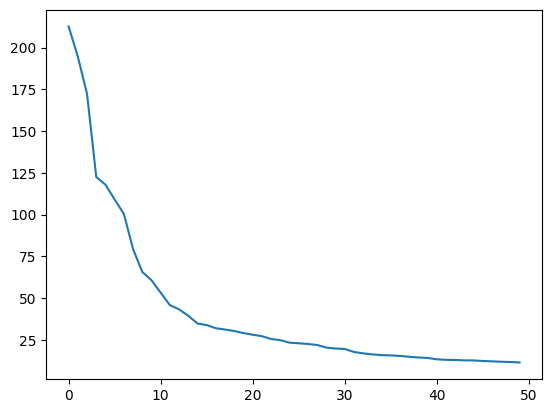

In [25]:
# plt.plot(np.cumsum(all_data.uns['pca']['variance_ratio']))
plt.plot(all_data.uns['pca']['variance'])

In [26]:
# scanpy.pp.pca(all_data, n_comps=50, mask_var="highly_variable", random_state=RANDOM_STATE)

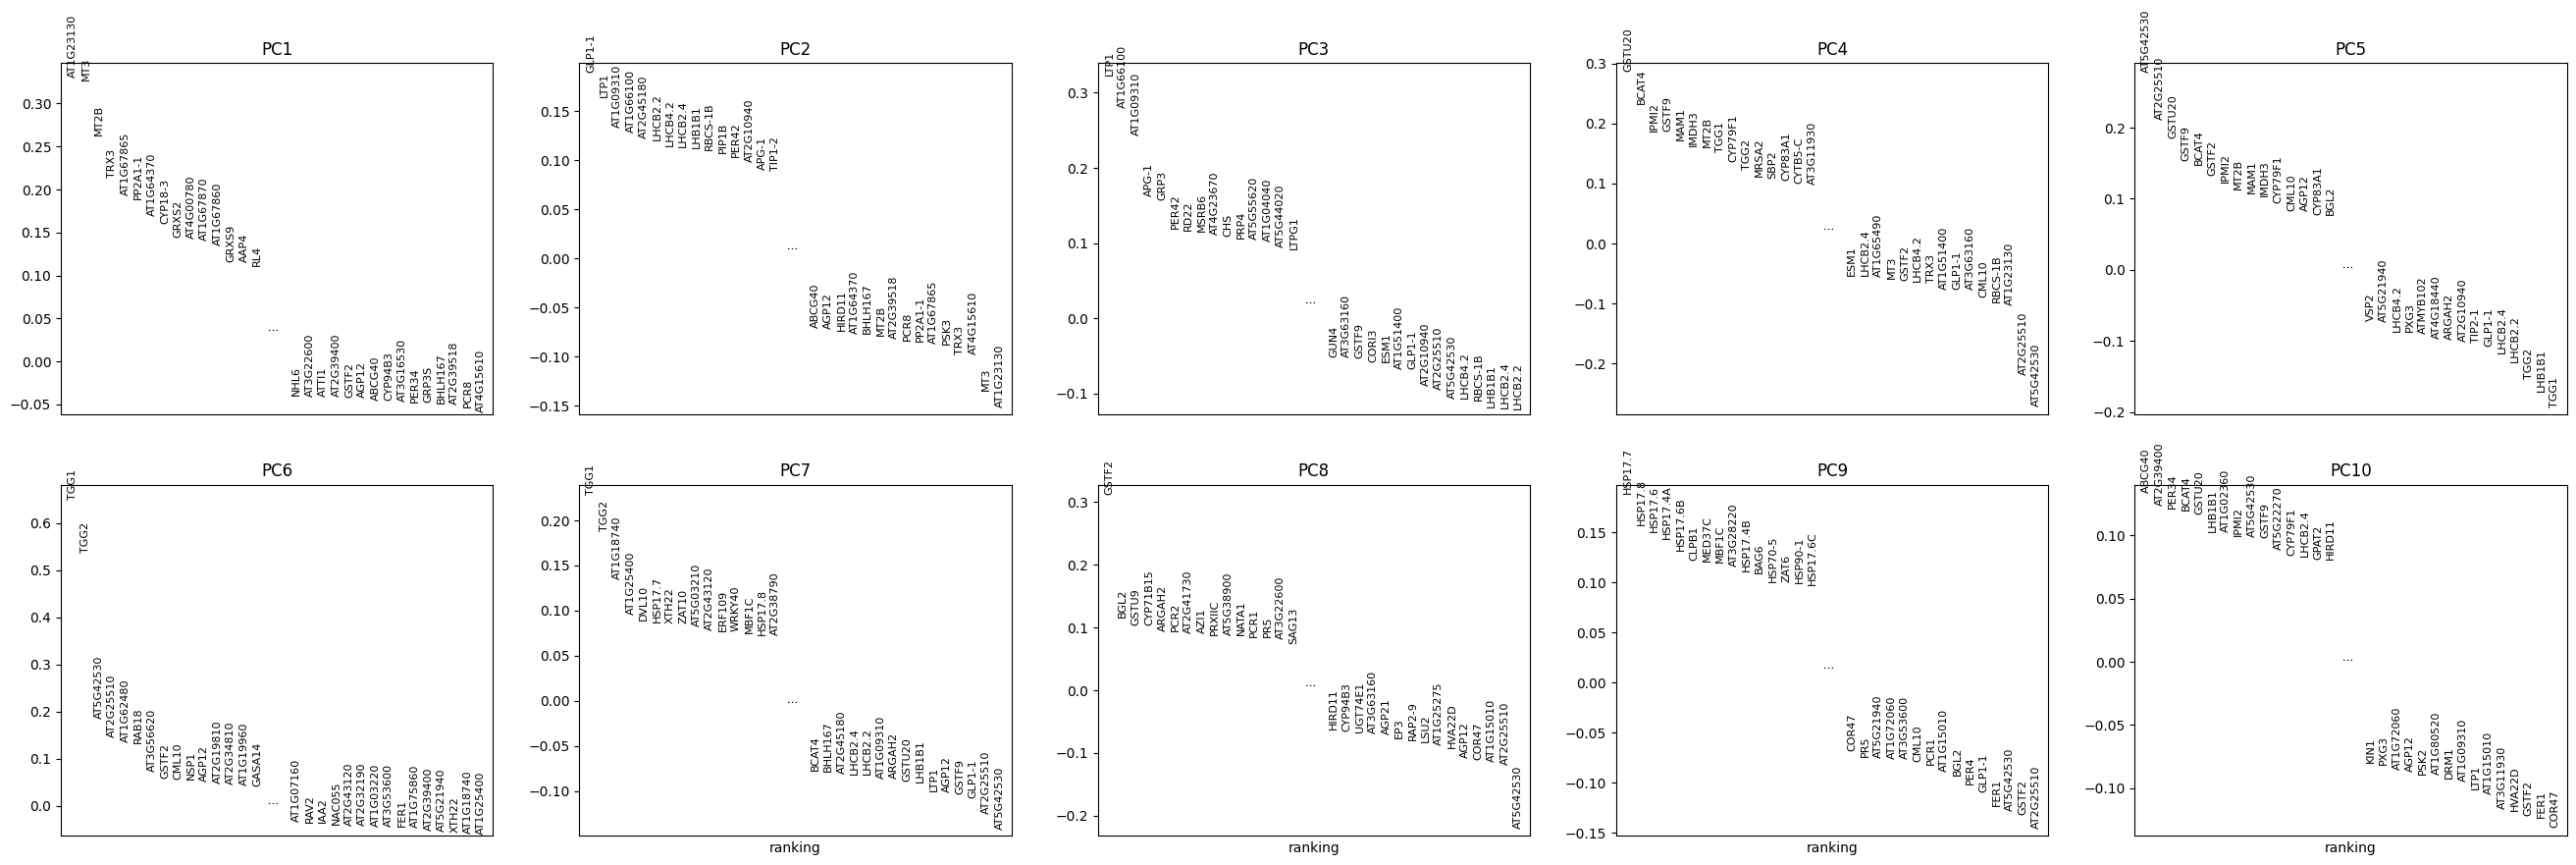

In [27]:
scanpy.pl.pca_loadings(all_data, components=range(1,11))

In [28]:
all_data.uns['pca']

{'params': {'zero_center': True,
  'use_highly_variable': False,
  'mask_var': None},
 'variance': array([212.68802  , 194.58232  , 172.19568  , 122.5051   , 117.8645   ,
        109.002716 , 100.35649  ,  79.356415 ,  65.62024  ,  60.635967 ,
         53.17592  ,  45.705284 ,  43.176224 ,  39.34602  ,  34.697376 ,
         33.741623 ,  31.854794 ,  31.062794 ,  30.188923 ,  28.934866 ,
         27.986538 ,  27.098543 ,  25.421434 ,  24.683146 ,  23.213985 ,
         22.836678 ,  22.43312  ,  21.81973  ,  20.262054 ,  19.706959 ,
         19.420856 ,  17.644947 ,  16.813042 ,  16.174978 ,  15.737928 ,
         15.566522 ,  15.273544 ,  14.749256 ,  14.336097 ,  14.065968 ,
         13.228379 ,  12.926717 ,  12.820925 ,  12.6153965,  12.562894 ,
         12.226381 ,  12.031274 ,  11.779803 ,  11.615733 ,  11.337873 ],
       dtype=float32),
 'variance_ratio': array([0.03873113, 0.03543403, 0.03135736, 0.02230855, 0.02146348,
        0.01984973, 0.01827522, 0.01445104, 0.01194964, 0.0110

In [29]:
scanpy.pp.neighbors(all_data, n_neighbors=10, n_pcs=50, random_state=RANDOM_STATE)

2024-12-12 10:07:46.019469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:07:46.023857: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:07:46.033130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:07:46.047319: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 10:07:46.050890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:07:46.060275: I tensorflow/core/platform/cpu_feature_gu

In [30]:
!pip install louvain

In [31]:
scanpy.tl.louvain(all_data, resolution=0.70)

## UMAP


In [32]:
scanpy.tl.umap(all_data, random_state=RANDOM_STATE)

<Figure size 1000x1000 with 0 Axes>

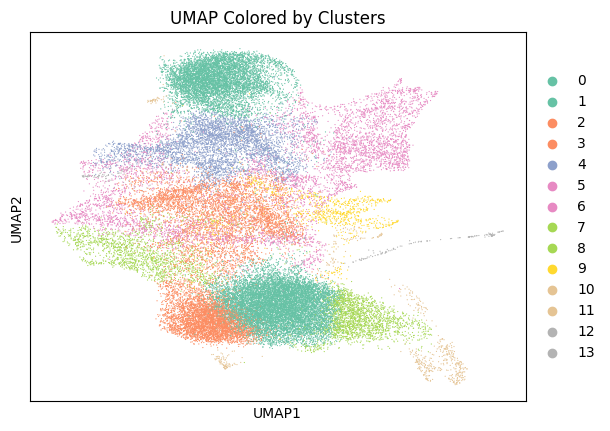

In [33]:
plt.figure(figsize=(10, 10))
scanpy.pl.umap(all_data, color='louvain', 
           palette='Set2',
           title='UMAP Colored by Clusters')
# plt.tight_layout()
plt.show()

In [34]:
# sorted(all_data.obs['leiden'].unique().astype(int))

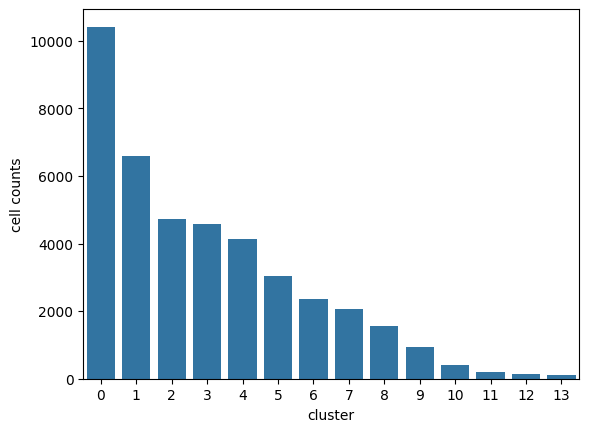

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data={}
for v in sorted(all_data.obs['louvain'].unique().astype(int)):
    data[v]=all_data[all_data.obs['louvain']==str(v)].shape[0]# /all_data.shape[0]*100
df = pd.DataFrame.from_dict(data, orient='index', columns=['cell counts'])    
df['cluster'] = df.index
df =df.reset_index(drop=True)
sns.barplot(data=df, x='cluster', y='cell counts')
plt.show()


In [36]:
import warnings
warnings.filterwarnings("ignore")
scanpy.tl.rank_genes_groups(all_data, 'louvain', method='wilcoxon') # "t-test"

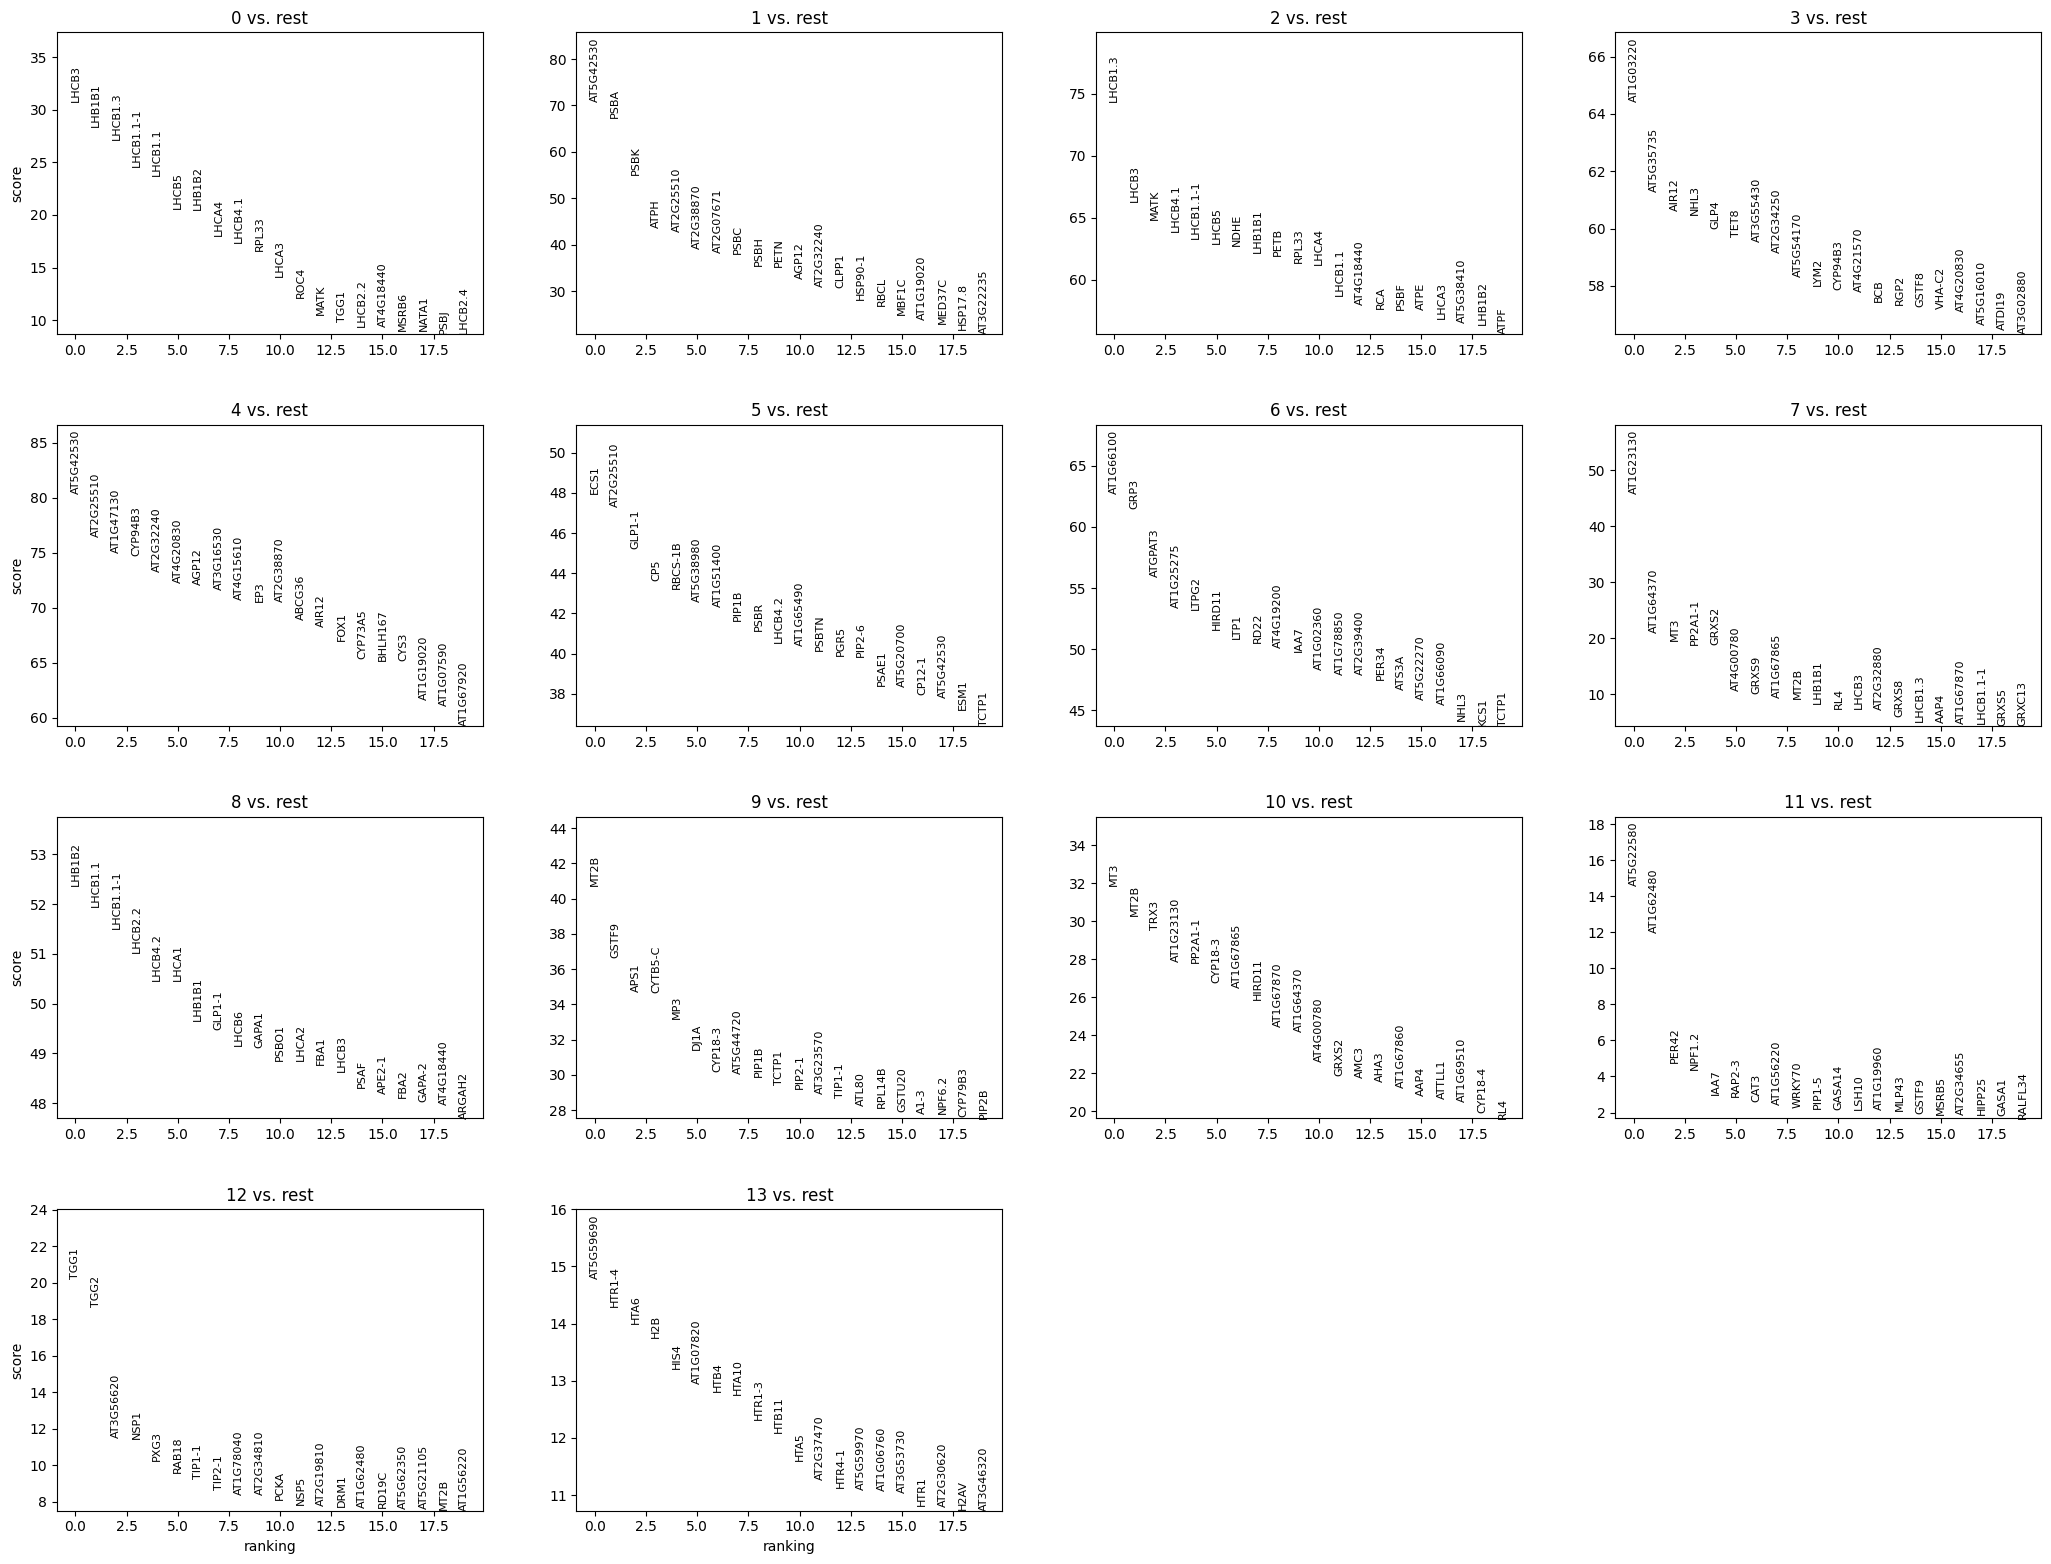

In [37]:
scanpy.pl.rank_genes_groups(all_data, n_genes=20, sharey=False)

# Comparar clusters con Seurat

In [38]:
cell_names = all_data.obs_names

In [39]:
cluster_assignments = all_data.obs["louvain"]

# import pandas as pd
cell_cluster_df = pd.DataFrame({
    "cell": cell_names,
    "cluster_scanpy": cluster_assignments
})

In [40]:
cell_cluster = cell_cluster_df["cluster_scanpy"].astype(int)

In [41]:
seurat_cluster_142 = pd.read_csv("/mnt/rodrigo/Postdoc/scrna-pipeline/output/output_seed142/cells_by_cluster.csv").iloc[:,1:]

In [42]:
seurat_cluster_142 = pd.read_csv("/mnt/rodrigo/Postdoc/scrna-pipeline/output/output_seed142/cells_by_cluster.csv").iloc[:,1:]
seurat_cluster_142.columns = ['cell', 'cluster_seurat']
seurat_cluster_242 = pd.read_csv("/mnt/rodrigo/Postdoc/scrna-pipeline/output/output_seed242/cells_by_cluster.csv").iloc[:,1:]
seurat_cluster_242.columns = ['cell', 'cluster_seurat']

seurat_cluster_142 = seurat_cluster_142.set_index("cell").iloc[:,0]
seurat_cluster_242 = seurat_cluster_242.set_index("cell").iloc[:,0]

In [43]:
contingency_matrix = pd.crosstab(cell_cluster, seurat_cluster_142)

In [44]:
fraction_matrix = (contingency_matrix / contingency_matrix.apply(sum,axis=0)).round(4) * 100

In [45]:
styled_df = fraction_matrix.round(2).style.map(lambda x: "font-weight: bold" if x > 50 else "").format("{:.2f}")
styled_df

cluster_seurat,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cluster_scanpy,,,,,,,,,,,,,,
0,63.39,0.04,36.57,0.84,0.00,7.44,0.00,0.93,3.16,0.17,0.48,1.35,0.00,0.00
1,0.01,97.82,0.40,0.03,4.94,0.04,43.73,2.51,3.48,10.51,3.25,1.14,2.20,0.00
2,23.07,0.00,33.98,0.78,0.07,7.21,0.00,0.05,0.00,0.00,0.00,0.31,0.00,0.73
3,0.07,0.08,17.64,77.23,3.61,5.21,2.77,0.70,68.37,2.34,14.53,8.73,0.00,2.19
4,0.00,0.39,0.87,5.88,86.76,0.04,48.94,1.76,2.35,6.09,0.76,1.66,0.00,0.73
5,0.01,0.88,0.37,10.37,3.19,36.75,3.89,0.28,10.36,63.05,2.29,58.73,0.40,0.00
6,0.10,0.00,0.85,0.39,0.11,0.31,0.24,93.32,6.07,13.18,0.10,0.83,0.00,5.11
7,12.24,0.00,5.47,0.00,0.00,1.39,0.00,0.09,2.59,0.00,0.00,0.21,21.00,0.00
8,0.07,0.00,3.18,3.46,0.04,39.76,0.04,0.00,1.21,0.08,0.96,25.57,0.20,1.46


In [46]:
seurat_cluster_142.sample(60)

cell
GTAGAAAGTGTTCAGT-1     4
CTGGTCTCACGTCATA-1    10
AAGCGAGGTTTGTGGT-1     7
TTTGACTAGGGCCCTT-1     1
ATACTTCTCGAGCCTG-1     6
TCTTGCGGTTGCCGCA-1     2
TACCTCGCAGGTCCCA-1     1
ATAGACCCACGGCACT-1    12
TGATTCTAGACATCCT-1     2
TCAAGACGTCGAATTC-1     7
CCACTTGAGTGAGGTC-1     0
ACGCACGGTCACGCTG-1     6
TCTGGCTAGTAGGGTC-1     0
CTGTCGTTCACTCTTA-1    10
CTAACCCAGCGTGAAC-1     4
ATTCACTGTTGCAACT-1     1
CATACAGCATGGCCAC-1     4
ATACTTCGTATGCTTG-1     5
GAAGTAATCACAGTGT-1     0
TTGTTCACAAGTGCAG-1     0
AATTCCTTCATTTGGG-1     3
AGGGCTCAGTGCGTCC-1     0
AACCACAGTAACAGTA-1     6
GTACAGTCATTGCTGA-1    11
CCGTTCAAGCTAGAAT-1     0
AAGACAAGTAGACAAT-1     9
TCGACGGGTATCGCTA-1    11
AGGATCTAGACTCATC-1     3
CCCTTAGTCCCTAGGG-1     5
ATTTCACGTTACACTG-1     1
ACTTATCTCGCTACAA-1     1
CAAGCTAAGCTGACCC-1     4
TCCTCCCCACTGGAAG-1     2
CGCAGGTCATTCTGTT-1     2
ACTGTCCTCGTTACCC-1     5
CATTGCCAGCAAATCA-1    10
TACTTACAGATTCGAA-1     0
CCTATCGGTGGTTCTA-1     0
CTAGGTAAGACCTCAT-1     5
ATCACTTCAATACGCT-1  

Our clusters:

In [47]:
genes_in_my_clusters = pd.DataFrame(all_data.uns['rank_genes_groups']['names']).head(200)

In [48]:
for i in range(genes_in_my_clusters.shape[0]):
    for j in range(genes_in_my_clusters.shape[1]):
        genes_in_my_clusters.iloc[i,j] = genename_mapping.get(genes_in_my_clusters.iloc[i,j], genes_in_my_clusters.iloc[i,j])

In [49]:
genes_in_my_clusters = { i: set(genes_in_my_clusters[str(i)]) for i in range(genes_in_my_clusters.shape[1])}

Clusters in paper:

In [50]:
sheet_names = [  "C0C4C10C11 healthy mesophyl", 
  "C1 responsive epidermal cells",
  "C2 vascular S cells",
  "C5",
  "C8 responsive mesophyl cells",
  "C9 healthy epidermal cells",
  "C13",
  "C16 guard cells"
]

genes_in_cluster = dict()

for cluster in sheet_names:
    supp_material_clusters = pd.read_excel("~/Postdoc/Papers/AT_PST_ScienceDirect_files_06Nov2024_13-40-25.581/1-s2.0-S2590346223002043-mmc5.xlsx", sheet_name=cluster)
    genes = supp_material_clusters[~supp_material_clusters['Gene model'].isna()]["Gene model"]
    genes_in_cluster[cluster] = set(genes.to_list())

In [51]:
conting_matrix = np.zeros((len(genes_in_my_clusters), len(genes_in_cluster)), int)

In [52]:
for i, (cluster_i, genes_i) in enumerate(genes_in_my_clusters.items()):
    for j, (cluster_j, genes_j) in enumerate(genes_in_cluster.items()):
        conting_matrix[i,j] = len(genes_i.intersection(genes_j))

In [53]:
pd.DataFrame(conting_matrix).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,5,9,6,20,20,0,0,21,7,0,1,1,16
1,1,6,10,14,17,0,84,1,0,0,5,0,3,0
2,2,1,4,0,1,2,0,3,2,30,4,9,9,0
3,0,0,0,0,6,0,0,0,0,0,0,0,0,0
4,0,9,0,0,0,2,1,0,0,0,3,0,0,0
5,0,1,0,0,0,1,8,1,2,1,2,7,4,0
6,1,3,0,0,0,0,0,0,0,0,0,0,0,0
7,5,0,1,0,0,0,0,2,0,0,0,5,17,0


### Marker genes

In [54]:
Guard_cell = ['GC-AT5G25980','GC-AT5G48485','GC-AT1G62480','GC-AT3G16400','GC-AT2G15830','GC-AT1G71050','GC-AT2G19810','GC-AT4G37870','GC-AT5G66400','GC-AT3G23730','GC-AT3G24140','GC-AT5G66440','GC-AT3G56620','GC-AT4G37430','GC-AT2G34655','GC-AT2G47260','GC-AT5G42970','GC-AT3G58640','GC-AT1G23170','GC-AT1G29050']
Companion_cell = ['CC-AT1G23130','CC-AT1G67865','CC-AT1G64370','CC-AT4G19840','CC-AT2G18328','CC-AT5G18600','CC-AT1G67860','CC-AT1G67870','CC-AT5G45350','CC-AT2G32870','CC-AT5G04080','CC-AT5G22090','CC-AT4G00780','CC-AT1G07610','CC-AT4G16008','CC-AT1G06830','CC-AT2G16740','CC-AT2G30540','CC-AT4G16000','CC-AT4G15690']
Epidermia_cell = ['EC-AT2G38540','EC-AT1G66100','EC-AT1G09310','EC-AT3G51600','EC-AT5G25610','EC-AT5G44020','EC-AT3G16370','EC-AT2G27385','EC-AT3G26450','EC-AT1G68530','EC-AT2G32690','EC-AT4G04840','EC-AT4G23670','EC-AT1G29660','EC-AT5G13930','EC-AT5G64770','EC-AT4G39330','EC-AT1G29670','EC-AT1G55260','EC-AT2G26250']
Mesophyl_cell = ['MC-AT2G10940','MC-AT5G38430','MC-AT3G08940','MC-AT1G72610','MC-AT3G27690','MC-AT2G05070','MC-AT1G12090','MC-AT1G29910','MC-AT2G34420','MC-AT2G34430','MC-AT1G15820','MC-AT2G21330','MC-AT1G06680','MC-AT3G59400','MC-AT2G05100','MC-AT1G67090','MC-AT3G54890','MC-AT5G66570','MC-AT4G38970','MC-AT1G44575']
Mesophyl_cell_2 = ['MC2-AT1G18740','MC2-AT1G74930','MC2-AT1G27730','MC2-AT2G44840','MC2-AT1G80840','MC2-AT3G44260','MC2-AT5G12030','MC2-AT5G12020','MC2-AT1G74450','MC2-AT4G24570','MC2-AT3G56880','MC2-AT1G71000','MC2-AT5G66650','MC2-AT4G27652','MC2-AT3G46230','MC2-AT3G12580','MC2-AT3G55980','MC2-AT4G34410','MC2-AT5G52050','MC2-AT1G07400']
Hydathode_cell = ['HC-AT3G16670','HC-AT3G05730','HC-AT3G16660','HC-AT1G56710','HC-AT3G09330','HC-AT1G22900','HC-AT1G08090','HC-AT4G36260','HC-AT4G32950','HC-AT2G43610','HC-AT4G23550','HC-AT2G19990','HC-AT1G62510','HC-AT2G33175','HC-AT2G38940','HC-AT3G14060','HC-AT3G60700','HC-AT1G19610','HC-AT5G60910']#,'HC-AT1G08757']
S_cell = ['SC-AT1G78370','SC-AT3G19710','SC-AT2G30860','SC-AT1G80520','SC-AT2G43100','SC-AT5G23010','SC-AT5G02380','SC-AT2G22330','SC-AT3G14990','SC-AT2G46650','SC-AT2G26690','SC-AT5G14200','SC-AT2G22860','SC-AT5G01600','SC-AT4G14040','SC-AT3G11930','SC-AT2G37170','SC-AT3G15450','SC-AT5G03610','SC-AT1G11580']

# Compare to Seurat

In [55]:
open("2000_highly_variable_genes.txt", "w").write("\n".join(all_data.var['highly_variable'][all_data.var['highly_variable']].index.to_list()))
highly_variable_scanpy = set(pd.read_csv("2000_highly_variable_genes.txt").iloc[:,0])

highly_variable_seurat = set(pd.read_csv("2000_highly_variable_genes_seurat.txt").iloc[:,0])

len(highly_variable_scanpy.intersection(highly_variable_seurat))

1219

In [56]:
highly_variable_seurat_seed142 = set(pd.read_csv("2000_highly_variable_genes_seurat_seed142.txt").iloc[:,0])
highly_variable_seurat_seed242 = set(pd.read_csv("2000_highly_variable_genes_seurat_seed242.txt").iloc[:,0])